# Modelling - Sentiment Analysis
## Portal da Queixa
### Changes may be required due to Portal da Queixa's continous updates

Lefties Group

In [1]:
# Import packages
import csv
import pandas as pd
import numpy as np
import nltk 
import re
import time
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

In [2]:

# Load dataset and assign tha datatypes
dtypes = {'controlID':'category','complainID':'category','complainStatus':'category','complainUser':'category',
 'complainTitle':'category','complainViews':'category','complainText':'category','complainDate':'category'}
df = pd.DataFrame(pd.read_excel("complains_data.xlsx", dtype=dtypes))

In [3]:
# Text preprocessing
def textPreProcess(rawText, removeHTML=True, charsToRemove = r'\?|\.|\!|\;|\.|\"|\,|\(|\)|\&|\:|\-|\_x000D_\n', removeNumbers=True, removeLineBreaks=False, specialCharsToRemove = r'[^\x00-\xfd]', convertToLower=True, removeConsecutiveSpaces=True):
    cleanedText = []
    for x in (rawText[:]): 
        
        # Remove HTML
        if removeHTML:
            procText = BeautifulSoup(x,'html.parser').get_text()

         # Remove punctuation and other special characters
        if len(charsToRemove)>0:
            procText = re.sub(charsToRemove,' ',procText)

        # Remove numbers
        if removeNumbers:
            procText = re.sub(r'\d+',' ',procText)

        # Remove line breaks
        if removeLineBreaks:
            procText = procText.replace('\n',' ').replace('\r', '')

        # Remove special characters
        if len(specialCharsToRemove)>0:
            procText = re.sub(specialCharsToRemove,' ',procText)

        # Normalize to lower case
        if convertToLower:
            procText = procText.lower() 

        # Replace multiple consecutive spaces with just one space
        if removeConsecutiveSpaces:
            procText = re.sub(' +', ' ', procText)

        # If there is a text, add it to the clean text         
        if procText != '':
            cleanedText.append(procText)
    return cleanedText

In [4]:
# Tokenize texts
def tokenize_words(texts):
    words_new = []
    for w in (texts[:]):
        w_token = word_tokenize(w)
        if w_token != '':
            words_new.append(w_token)
    return words_new

In [5]:
# Function to recreate text from words
def recreateText(words):
    text_new = []
    for w in (words[:]):
        temp_str = (' ').join(w)
        text_new.append(temp_str)
    return text_new

In [6]:
# Function to break texts into sentences
def tokenize_sentences(texts):
    sentences_new = []
    for s in (texts[:]):
        s_token = sent_tokenize(s)
        sentences_new.append(s_token)
    return sentences_new

In [7]:
# Function to remove stop words
def removeStopWords(texts, stop_words):
  procText = []
  for t in (texts[:]):
    cleaned_text = [w for w in t[:] if not w in stop_words]
    procText.append(cleaned_text)
  return procText

In [8]:
# Break the complains into a list of lists sentences
listOfSentences = tokenize_sentences(df.complainText)

In [9]:
# Create a dataframe with only the description
ppText = textPreProcess(df.complainText, charsToRemove='', removeLineBreaks=False, removeNumbers=False)
processedComplains =  pd.DataFrame(data=ppText, index=df.index, columns=['PreProcessedText']) 

In [10]:
df.complainText[0] #Analyzing the first 

'Recebi a minha encomenda no dia 19-04-2021 e imediatamente no dia a seguir, dia 20-04-2021 fiz a devolução de um dos artigos que não me agradou. _x000D_\nNa política de devolução desta empresa, caso seja em compra on-line como no meu caso, temos de fazer um pedido de devolução e então imprimir uma “etiqueta” com um código de barras e dados do remetente/destinatário. Pois seguindo todos estes passos, dirigi-me ao ponto de Recolha Celeritas que indicam no site. Exatamente nessa localização, são os postos CTT da minha localidade, tendo então entregue a encomenda nesse local. Paguei 4,99€ para enviar, aquando no site dizem ter um custo de 1,99€. Ontem, dia 04-05-2021 ainda não obtive qualquer retorno monetário, nem nenhuma indicação que procedi à devolução no próprio site. Entrei em contacto ao qual me pediram o talão. Infelizmente e por erro meu, já não tenho o talão, e expliquei que eles tem concerteza a entrada da minha embalagem no armazém, basta seguirem o código de barras que me env

In [11]:
listOfSentences[0]

['Recebi a minha encomenda no dia 19-04-2021 e imediatamente no dia a seguir, dia 20-04-2021 fiz a devolução de um dos artigos que não me agradou.',
 '_x000D_\nNa política de devolução desta empresa, caso seja em compra on-line como no meu caso, temos de fazer um pedido de devolução e então imprimir uma “etiqueta” com um código de barras e dados do remetente/destinatário.',
 'Pois seguindo todos estes passos, dirigi-me ao ponto de Recolha Celeritas que indicam no site.',
 'Exatamente nessa localização, são os postos CTT da minha localidade, tendo então entregue a encomenda nesse local.',
 'Paguei 4,99€ para enviar, aquando no site dizem ter um custo de 1,99€.',
 'Ontem, dia 04-05-2021 ainda não obtive qualquer retorno monetário, nem nenhuma indicação que procedi à devolução no próprio site.',
 'Entrei em contacto ao qual me pediram o talão.',
 'Infelizmente e por erro meu, já não tenho o talão, e expliquei que eles tem concerteza a entrada da minha embalagem no armazém, basta seguirem 

In [12]:
# Create DataFrame for sentences from the complains
sentences = pd.DataFrame(data=[item for elem in listOfSentences for item in elem], columns=['BaseText'])

In [13]:
# Add a column with the complain ID

sentencesPerComplain = []
for elem in listOfSentences:
  sentencesPerComplain.append(len(elem))
sentences['complainID'] = np.repeat(df["complainID"].values,sentencesPerComplain)

In [14]:
# Preprocess text 
sentences['PreProcessedText'] = textPreProcess(sentences['BaseText'])

In [15]:
# Get words to analyze the sentiments
sentences['Words'] =  tokenize_words(sentences['PreProcessedText'])

In [16]:
#Importing the sentiment analyzer from nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [17]:
# Create sentiment analysis object empty
analyser = SentimentIntensityAnalyzer()

In [19]:
# Process sentiment for all sentences from the complains and print the results per sentence

all_scores = []
for t in (sentences['PreProcessedText'][:]):
    score = analyser.polarity_scores(t)
    all_scores.append(score)

sentences['Sentiment'] = [c['compound'] for c in all_scores]
all_scores

[{'neg': 0.196, 'neu': 0.804, 'pos': 0.0, 'compound': -0.5267},
 {'neg': 0.061, 'neu': 0.939, 'pos': 0.0, 'compound': -0.296},
 {'neg': 0.128, 'neu': 0.872, 'pos': 0.0, 'compound': -0.296},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.18, 'neu': 0.82, 'pos': 0.0, 'compound': -0.296},
 {'neg': 0.121, 'neu': 0.879, 'pos': 0.0, 'compound': -0.296},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'compound': -0.296},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg'

In [20]:
# Define complain's sentiment as mean sentiment from  sentences
meanByComplain = sentences.groupby('complainID')['Sentiment'].mean()

df['Sentiment'] = meanByComplain[df['complainID']].values
ComplainsbyStatus = df[['complainID','complainStatus','Sentiment']].groupby(['complainID','complainStatus'], as_index=False).mean()
ComplainsbyStatus



,complainID,complainStatus,Sentiment
0,24795518,Aguarda resposta,NaN
1,24795518,Resolvida,NaN
2,24795518,Sem resolução,-0.098667
3,24808918,Aguarda resposta,NaN
4,24808918,Resolvida,NaN
...,...,...,...
487,58935721,Resolvida,NaN
488,58935721,Sem resolução,NaN
489,59476521,Aguarda resposta,-0.182427
490,59476521,Resolvida,NaN


/Users/LucianaNassar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Sentiment', ylabel='Density'>

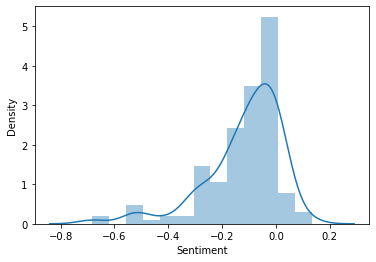

In [21]:
#Import packages for plots
import seaborn as sns
sns.distplot(df['Sentiment'])

In [22]:
pip install joypy

Note: you may need to restart the kernel to use updated packages.


In [23]:
import matplotlib.pyplot as plt


<ipython-input-24-e1ea1344a554>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  g = joypy.joyplot(data=df, column='Sentiment', by='complainStatus', ax=ax)


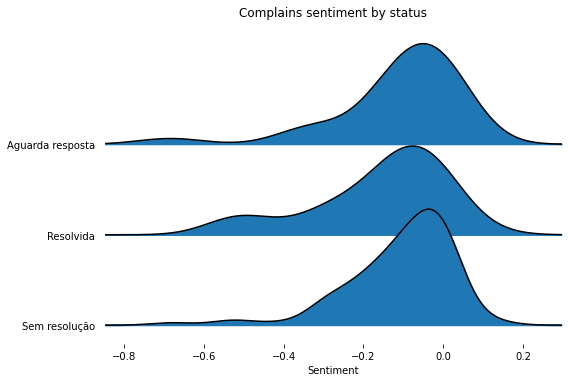

In [24]:
import joypy
# Draw
fig, ax = plt.subplots(figsize=(8,5))
g = joypy.joyplot(data=df, column='Sentiment', by='complainStatus', ax=ax)

# Decoration
plt.title("Complains sentiment by status")
plt.xlabel("Sentiment")
plt.rc('axes')
